<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/quickstart_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart

![](https://github.com/ai-fast-track/icevision/blob/fridge-tutorial/images/fridge-objects.png?raw=1)

## Introduction

This tutorial walk you through the different steps of training the fridge dataset. the IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

For more information about how the fridge dataset as well as its corresponding parser check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

## Installing IceVision and IceData

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Imports

In [1]:
from icevision.all import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
/home/farid/anaconda3/envs/mantis/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Choose Your Model and Backbone

You can choose your model from 3 model libraries:
* MMDetection
* Torchvision
* Ross Wightman (EfficientDet)

In [2]:
# display_model_choice_ui(mytask="keypoints")
model_ui = ModelChoiceUI(task="object_detection")
model_ui.display()

Dropdown(description='Libraries', options=('', 'MMDetection', 'Ross Wightman', 'Torchvision'), value='')

Dropdown(description='Models', options=('',), value='')

Dropdown(description='Backbones', options=('',), value='')

In [4]:
model_type, backbone = model_ui.get_model_info()
model_type, backbone

(<module 'icevision.models.mmdet.models.fcos' from '/home/farid/repos/airctic/icevision/icevision/models/mmdet/models/fcos/__init__.py'>,
 <icevision.models.mmdet.models.fcos.backbones.resnet_fpn.MMDetFCOSBackboneConfig at 0x7f42648d2880>)

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [ ]:
# Loading Data
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

In [ ]:
# Parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images")

In [ ]:
# Parsing
train_records, valid_records = parser.parse()

In [ ]:
parser.class_map

<ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>

## Train and Validation Dataset Transforms

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

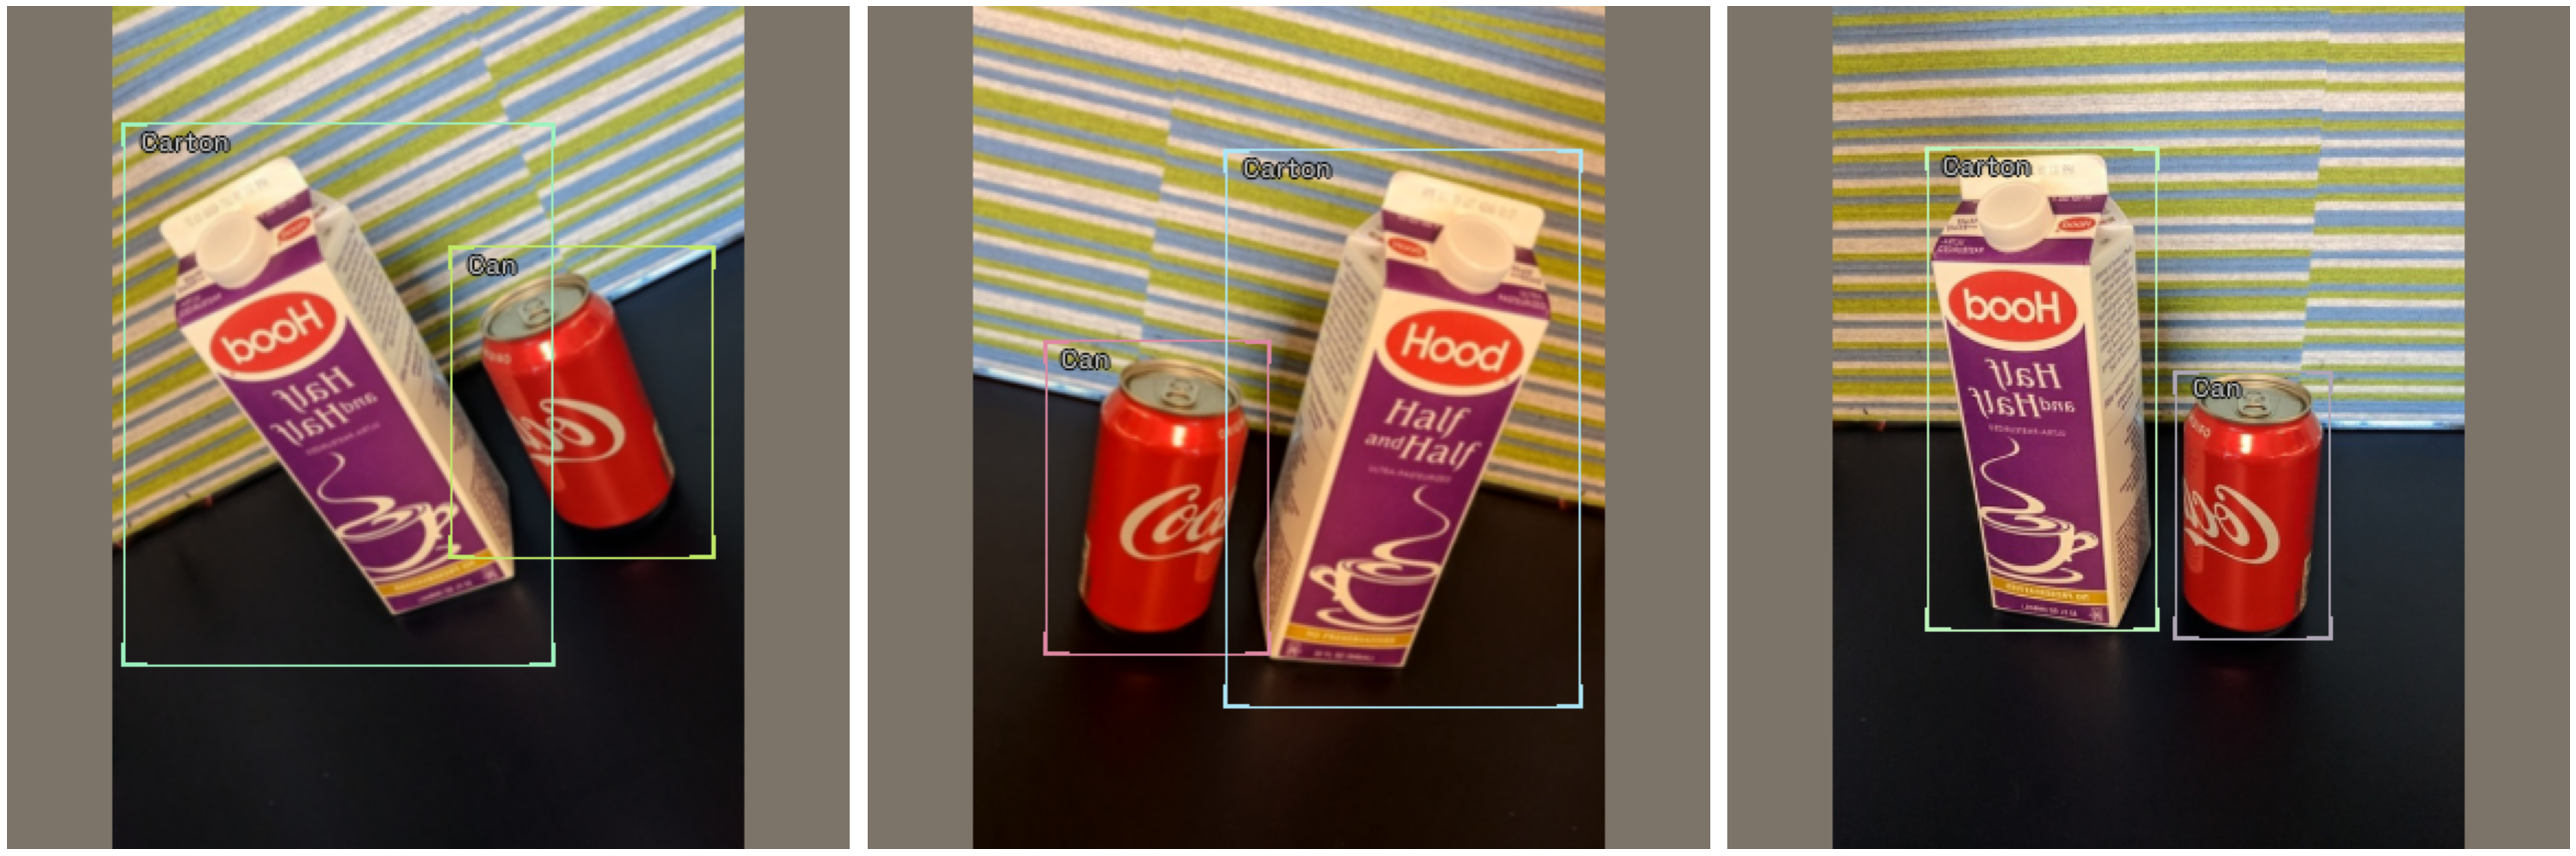

In [ ]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## DataLoader

In [ ]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

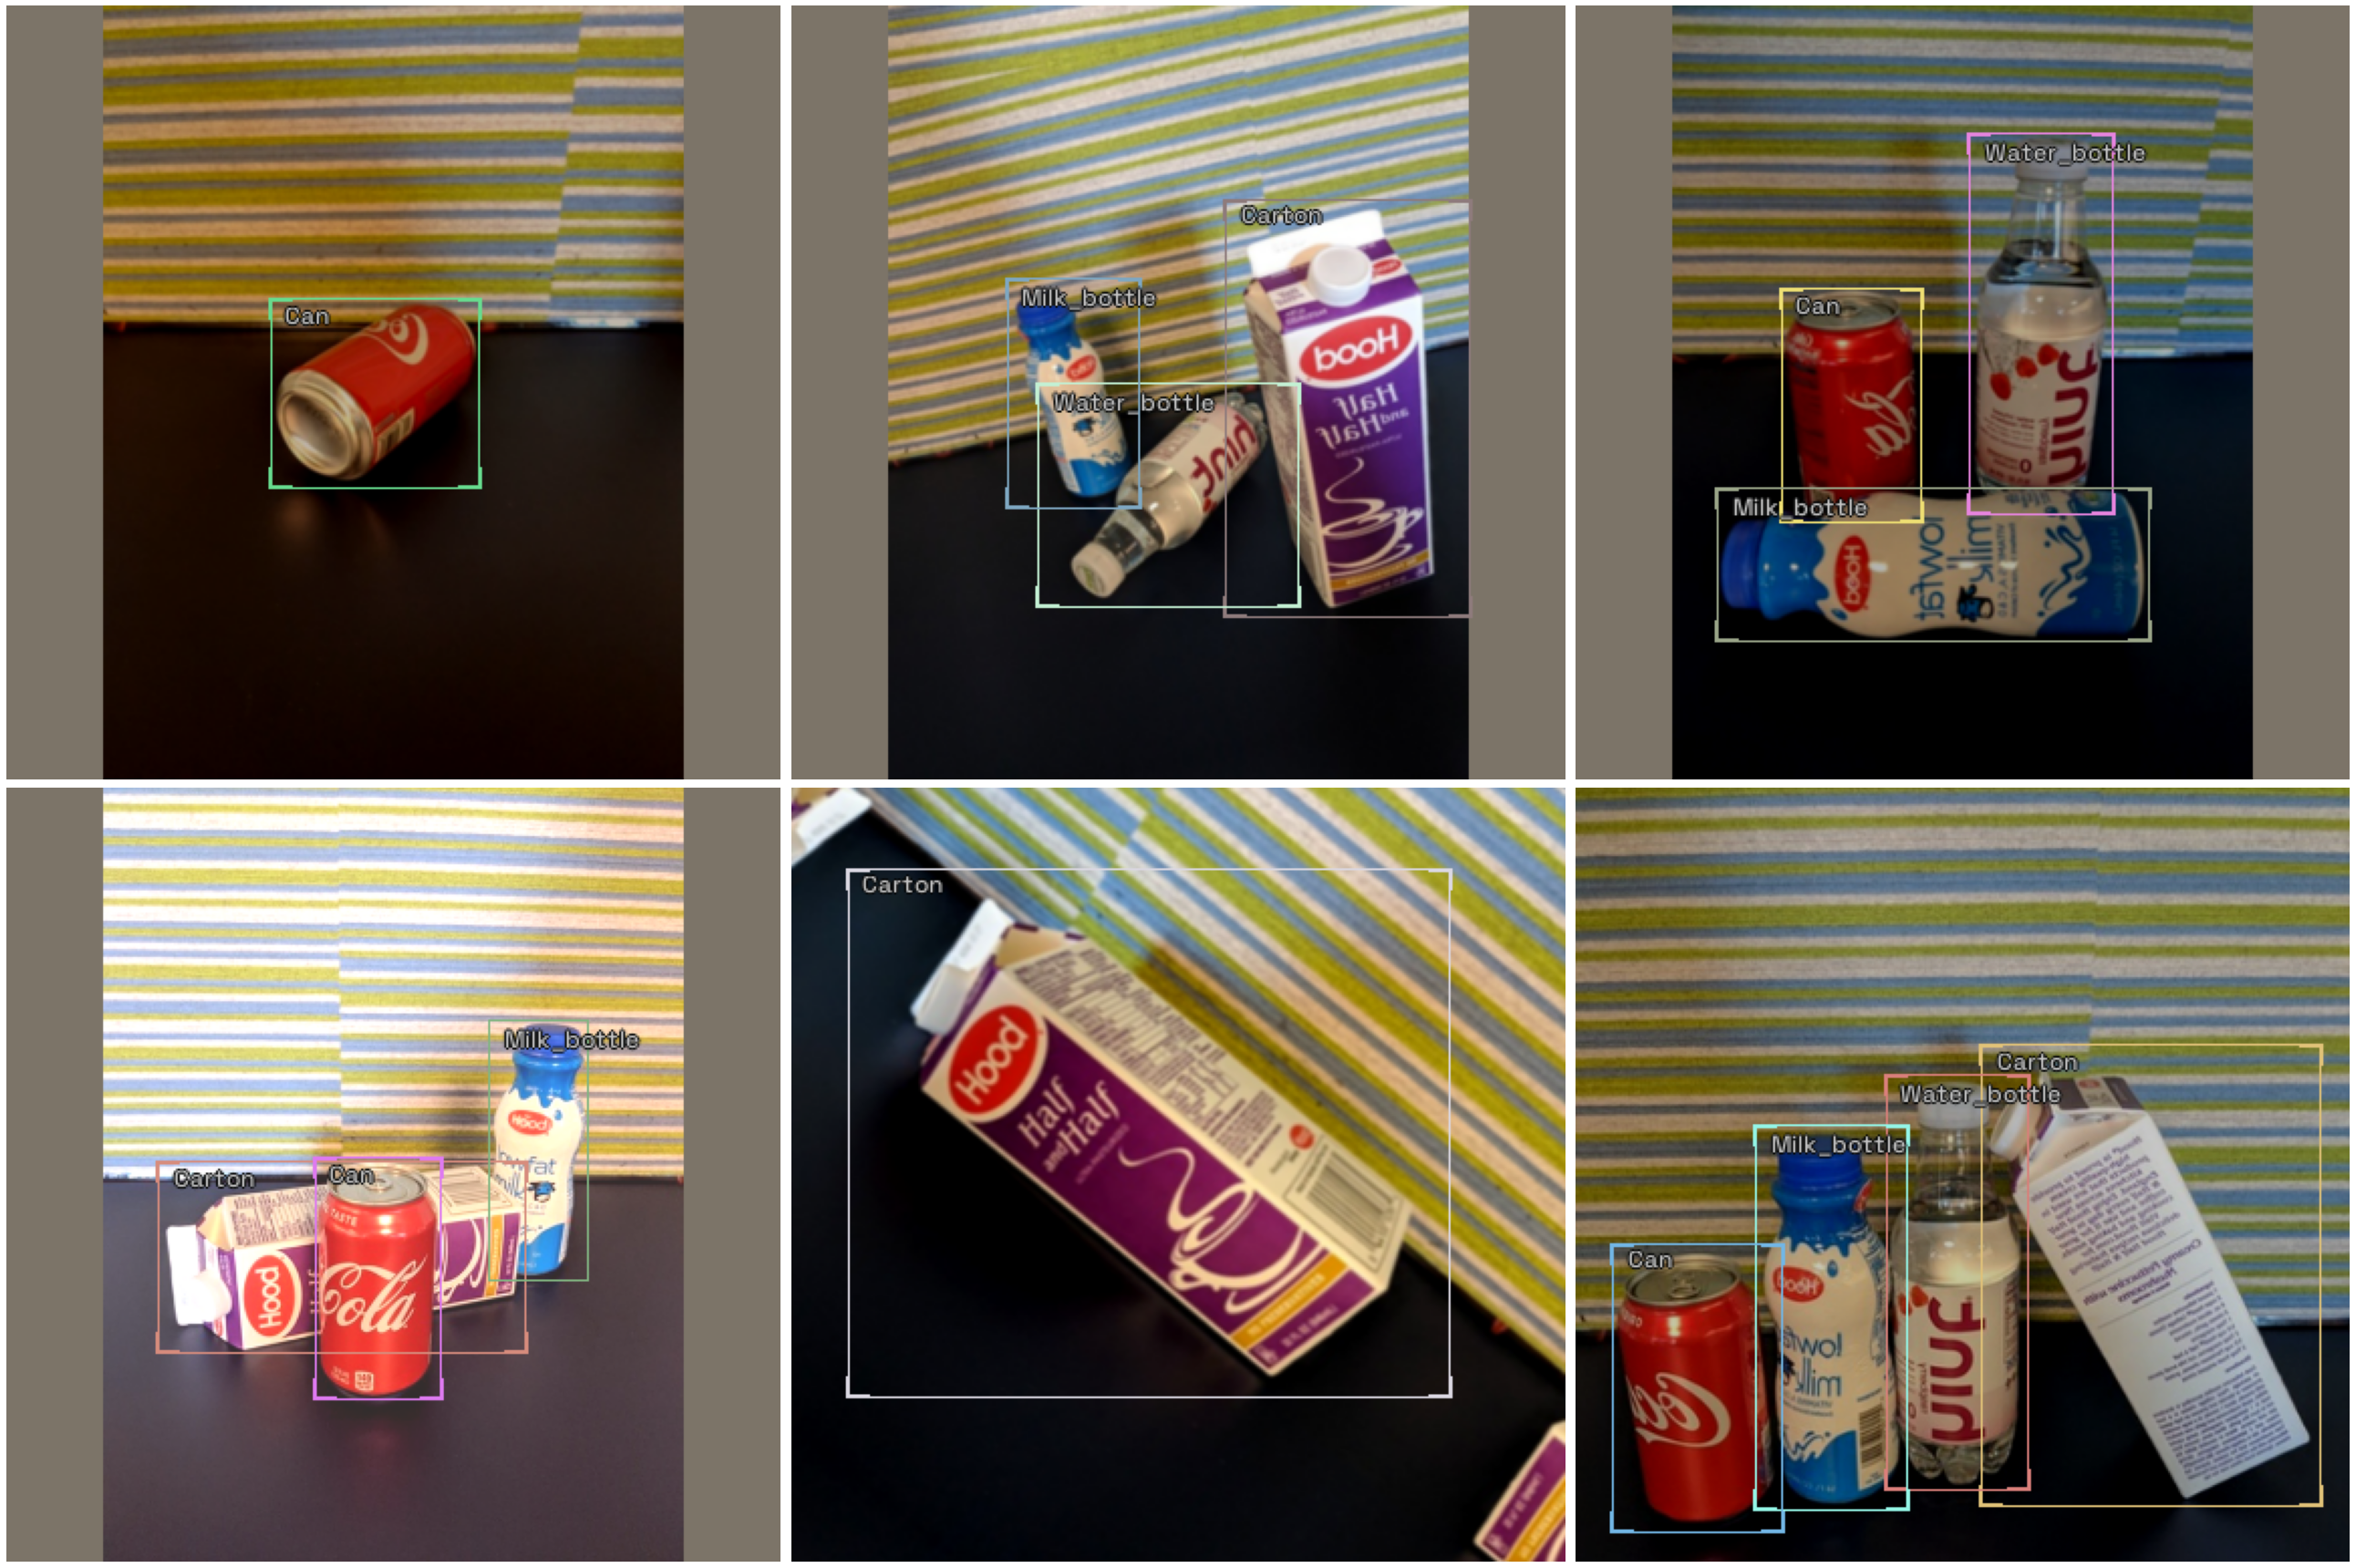

In [ ]:
# show ba
model_type.show_batch(first(valid_dl), ncols=4)

## Model

In [ ]:
# pretrained=True is a default setting, and can be omitted
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

# EfficietDet requires img_size
# model = model_type.model(backbone=backbone(), num_classes=len(parser.class_map), img_size=384)

  0%|          | 0/425491652 [00:00<?, ?B/s]

The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.Size([4, 256]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.1.fc_cls.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.Size([4, 256]).
size mismatch for roi_head.bbox_head.1.fc_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.2.fc_cls.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.Size([4, 256]).
size mismatch for roi_head.bbox_head.2.fc_cls.bias: copying a param with shape torch.Size([80]) from checkpoin

## Metrics

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [ ]:
# learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

# For MMDetection models. COCOMetric is not supported yet.
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model)

SuggestedLRs(lr_min=7.131081656552851e-05, lr_steep=3.447019844315946e-05)

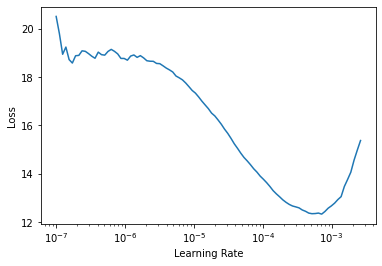

In [ ]:
# learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
learn.lr_find(end_lr=0.005)

In [ ]:
learn.fine_tune(20, 1e-4, freeze_epochs=1)

### Training using Lightning

In [ ]:
class LightModel(efficientdet.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Show Results

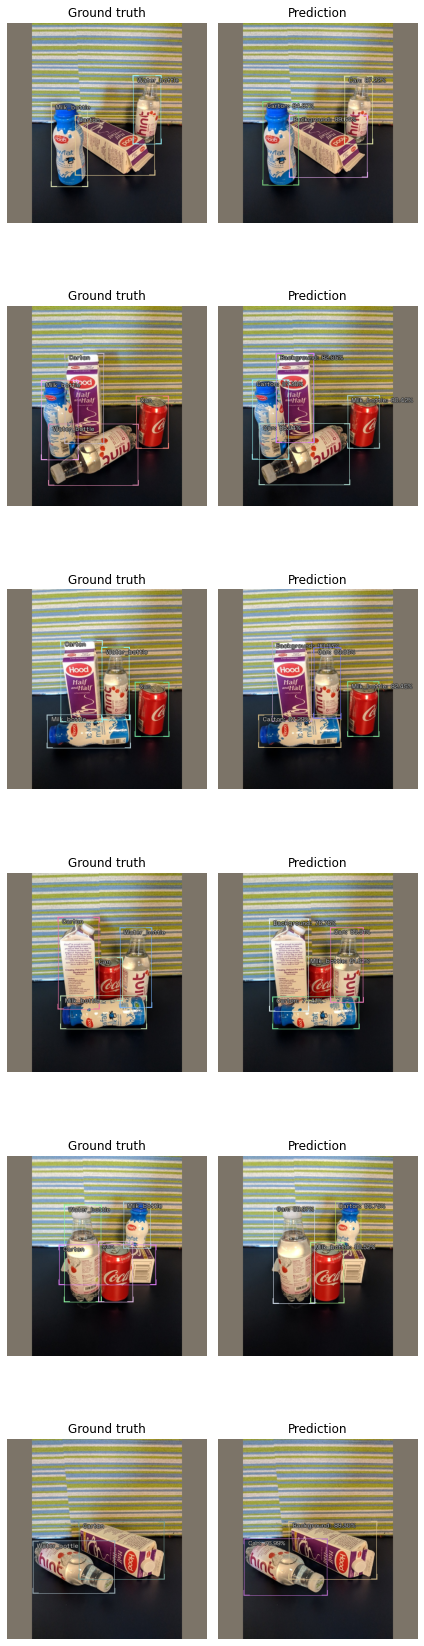

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 


In [ ]:
preds = model_type.predict(model, valid_ds)

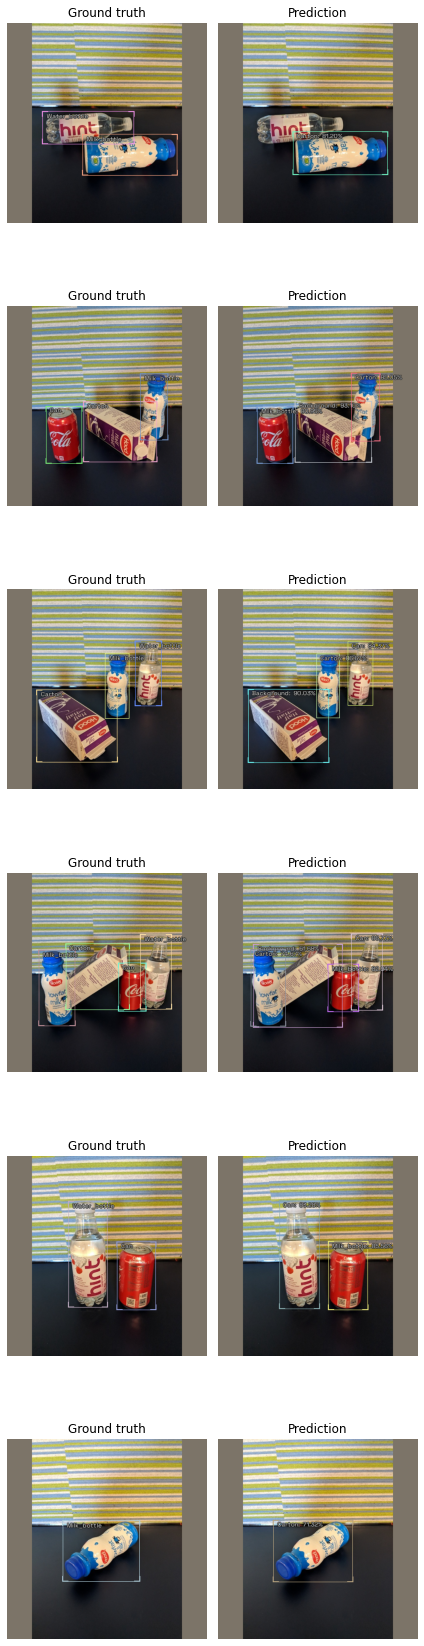

In [ ]:
show_preds(
    preds=preds[:6],
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).